## Proof-of-concept

#### This notebook present a real-world use case of the presented approach.
* We have used the model trained [here](./Model_development.ipynb) to get predictions on two different assemblages of Cova das Lapas (n=15) and Gruta da Marmota (n=10). 
* These samples were analysed chemically and mineralogically specifically to be used as ground truth
* Finally we evaluate the model performance computing its confusion matrix and its evaluation metrics

In [16]:
from pycaret.classification import *

import pandas as pd
import numpy as np
import re
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Load the data

In [2]:
#df = pd.read_csv("./intermediate_data/.csv", encoding = 'latin')
#df = pd.read_excel("./intermediate_data/.xlsx, engine='openpyxl')
df = pd.read_csv("./intermediate_data/proof_of_concept.csv", encoding = 'latin')


In [3]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id_inv  25 non-null     object 
 1   Mg      25 non-null     float64
 2   Al      25 non-null     float64
 3   Si      25 non-null     float64
 4   P       25 non-null     float64
 5   S       25 non-null     float64
 6   Cl      25 non-null     float64
 7   K       25 non-null     float64
 8   Ca      25 non-null     float64
 9   Sc      25 non-null     float64
 10  Ti      25 non-null     float64
 11  V       25 non-null     float64
 12  Cr      25 non-null     float64
 13  Mn      25 non-null     float64
 14  Fe      25 non-null     float64
 15  Co      25 non-null     float64
 16  Ni      25 non-null     float64
 17  Cu      25 non-null     float64
 18  Zn      25 non-null     float64
 19  Ga      25 non-null     float64
 20  Ge      25 non-null     float64
 21  As      25 non-null     float64
 22  Se  

#### This function load the pre-trained models, perform a prediction on the data and format the output dataframe

In [4]:
MODEL_NAMES = {
    'model1': 'strunz_classifier',
    'model2': 'classifier'
}

def prediction_function(df, model_key):
    """
    This function performs the following operations:
    * Loads the specified pre-trained model
    * Performs the probability prediction on the dataframe (df).
    * Filters the columns containing the word 'Score' for output formatting purposes
    * Selects the three highest probabilities, sorts them in descending order and presents them in a new column.
    * Finally it returns the dataframe with two new columns of results 'Label' and 'top_3 Probs'.
    """
    
    model = load_model(MODEL_NAMES[model_key])
    pred_prob = predict_model(estimator=model, data=df, raw_score=True)
    
    selected = [] 
    patron = re.compile('.*Score.*', re.IGNORECASE)
    
    for columna in pred_prob.columns:
        if patron.match(columna):
            selected.append(columna)
    
    def select_top_three_cols(row):
        top_three_cols = row.nlargest(3)
        top_three_cols_dict = dict(zip(top_three_cols.index, top_three_cols))
        return top_three_cols_dict
    
    top_three_cols = pred_prob[selected].apply(select_top_three_cols, axis=1)
    pred_prob['top_3_probs'] = top_three_cols
    
    pred_prob = pred_prob.drop(pred_prob[selected].columns, axis=1)
     
    return pred_prob

### Using the prediction function with the two models

In [5]:
# Model 1
preds = prediction_function(df, 'model1')
preds.rename(columns={'prediction_label': 'Predicted Major Class', 'top_3_probs': 'top_3_Major Class'}, inplace=True)
preds = preds.drop(['top_3_Major Class'], axis=1)


Transformation Pipeline and Model Successfully Loaded


In [6]:
# Model 2
preds2 = prediction_function(preds, 'model2')
preds2

Transformation Pipeline and Model Successfully Loaded


,id_inv,Mg,Al,Si,P,S,Cl,K,Ca,Sc,...,Hg,Tl,Pb,Th,y_true,xrd2,xrd3,Predicted Major Class,prediction_label,top_3_probs
0,MRO-S-25,0.000000,3.269514,3.110717,0.000000,0.237115,2.240352,0.000158,90.958466,0.000120,...,6.015040e-07,5.794024e-07,5.637383e-07,4.495017e-07,Fluorite,NaN,NaN,Halides,Fluorite,"{'prediction_score_Fluorite': 0.9567, 'predict..."
1,GTMT-26,0.000000,2.107244,1.795528,0.602159,0.474382,1.733755,0.000159,93.030128,0.000121,...,6.053030e-07,5.830618e-07,3.006684e-04,4.523407e-07,Fluorite,NaN,NaN,Halides,Fluorite,"{'prediction_score_Fluorite': 0.939, 'predicti..."
2,MRO_1581,10.536120,9.313109,44.244869,1.597565,1.997287,6.036622,0.000165,7.068465,0.000144,...,3.216680e-06,3.157030e-06,3.114063e-06,2.780701e-06,Clinochlore,NaN,NaN,Silicates,Clinochlore,"{'prediction_score_Clinochlore': 0.9637, 'pred..."
3,MRO_1836,0.000000,28.897903,40.323185,1.208307,0.466497,2.163752,21.502310,1.166194,0.000135,...,3.018606e-06,2.962629e-06,2.922307e-06,2.609473e-06,Muscovite,NaN,NaN,Silicates,Muscovite,"{'prediction_score_Muscovite': 0.5687, 'predic..."
4,MRO_1890,0.000000,29.416237,35.391479,1.151213,0.874422,2.691249,23.828667,0.899188,0.000134,...,3.006833e-06,2.951075e-06,2.910910e-06,2.599296e-06,Muscovite,NaN,NaN,Silicates,Muscovite,"{'prediction_score_Muscovite': 0.9622, 'predic..."
5,MRO_1985A,0.000000,19.010382,22.319599,8.575088,2.722408,14.522683,0.000157,11.104357,0.000137,...,3.060765e-06,3.004007e-06,2.963122e-06,2.645919e-06,Clinochlore,NaN,NaN,Silicates,Clinochlore,"{'prediction_score_Clinochlore': 0.5361, 'pred..."
6,MRO_1999,0.000000,23.779680,24.164476,6.535106,2.098606,10.985693,0.914940,5.413211,0.000142,...,3.181722e-06,3.122720e-06,3.080220e-06,2.750481e-06,Clinochlore,NaN,NaN,Silicates,Chlorite-serpentine,{'prediction_score_Chlorite-serpentine': 0.961...
7,MRO(N)2,0.000000,29.348356,34.880253,1.071741,0.593321,2.478651,18.738752,9.104530,0.000134,...,3.013336e-06,2.957457e-06,2.917206e-06,2.604917e-06,Muscovite,NaN,NaN,Silicates,Muscovite,"{'prediction_score_Muscovite': 0.9644, 'predic..."
8,MRO(N)3,0.000000,28.147934,36.798157,1.293025,0.649161,2.589902,23.795195,1.525216,0.000134,...,3.006502e-06,2.950750e-06,2.910590e-06,2.599010e-06,Muscovite,NaN,NaN,Silicates,Muscovite,"{'prediction_score_Muscovite': 0.9643, 'predic..."
9,MRO(N)5,0.000000,34.303707,36.722488,1.094201,0.654560,2.764978,20.582144,0.642881,0.000133,...,2.978852e-06,2.923612e-06,2.883822e-06,2.575107e-06,Muscovite,NaN,NaN,Silicates,Muscovite,"{'prediction_score_Muscovite': 0.966, 'predict..."


#### The dataframe with predictions is stored in intermediate_data folder

In [7]:

preds2.to_csv("./intermediate_data/proof_of_concept_predictions+fluor.csv") 

### Evaluation

**In this section we report the confusion matrix and the evaluation metrics for the proof of concept.**

In [8]:
preds2['y_pred'] = preds2['prediction_label']

predictions_filtered = preds2[['id_inv', 'y_true', 'y_pred']]

predictions_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id_inv  25 non-null     category
 1   y_true  25 non-null     category
 2   y_pred  25 non-null     object  
dtypes: category(2), object(1)
memory usage: 1.3+ KB


In [9]:
y_true = predictions_filtered['y_true']
y_pred = predictions_filtered['y_pred']
etiquetas_true = y_true.unique().tolist() #
etiquetas_pred = y_pred.unique().tolist()

y_pred.nunique()

6

In [10]:
etiquetas = etiquetas_pred + etiquetas_true
etiquetas

['Fluorite',
 'Clinochlore',
 'Muscovite',
 'Chlorite-serpentine',
 'Talc',
 'Variscite',
 'Fluorite',
 'Clinochlore',
 'Muscovite',
 'Talc']

In [11]:
# Combinar las dos series en una sola serie
etiquetas_combinadas = pd.concat([y_true, y_pred], ignore_index=True)

# Obtener los elementos únicos de la serie combinada
etiquetas_unicas = np.unique(etiquetas_combinadas)

# Crear una nueva serie con los elementos únicos
unique_series = pd.Series(etiquetas_unicas)

# Mostrar los resultados
unique_series.nunique()

6

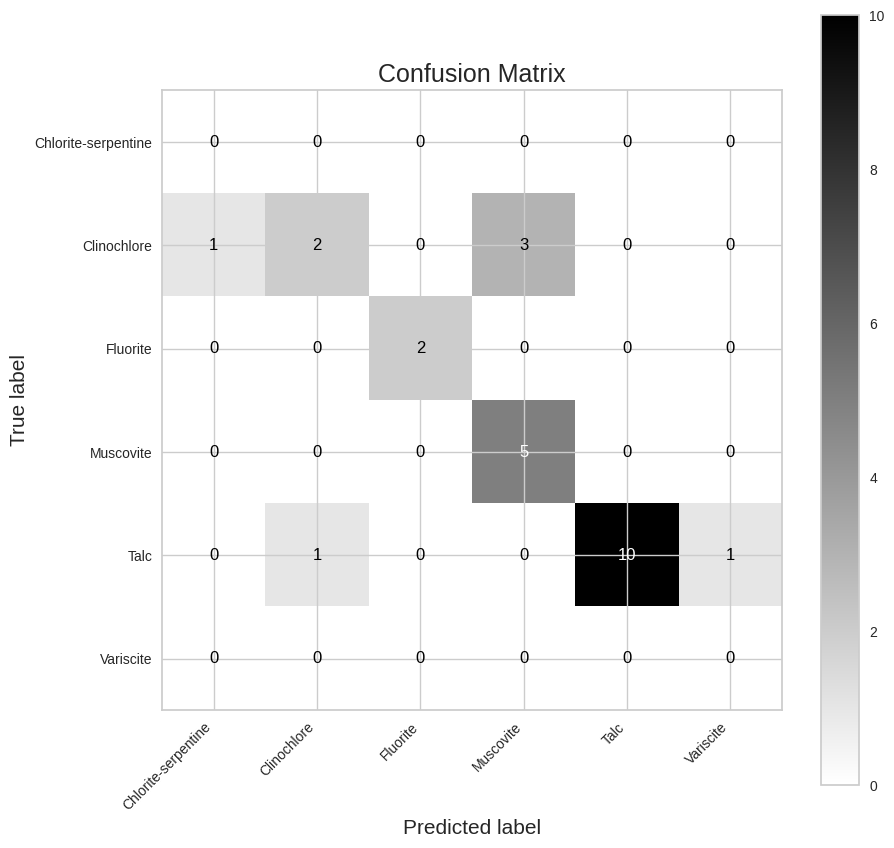

In [15]:
cm = confusion_matrix(y_true, y_pred, labels=unique_series)
cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_series)
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Etiqueta predicha', fontsize=15)
plt.ylabel('Etiqueta verdadera', fontsize=15)
cm_display.plot(ax=ax,cmap='binary')
cm_display.ax_.set_xticklabels(unique_series, rotation=45, ha='right', fontdict={'fontsize': 10})
cm_display.ax_.set_yticklabels(unique_series, fontdict={'fontsize': 10})
#plt.savefig('proof-of-concept_matrix.tiff',dpi=500)
plt.show()

In [13]:
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
class_rep

,precision,recall,f1-score,support
Chlorite-serpentine,0.000000,0.000000,0.000000,0.00
Clinochlore,0.666667,0.333333,0.444444,6.00
Fluorite,1.000000,1.000000,1.000000,2.00
Muscovite,0.625000,1.000000,0.769231,5.00
Talc,1.000000,0.833333,0.909091,12.00
Variscite,0.000000,0.000000,0.000000,0.00
accuracy,0.760000,0.760000,0.760000,0.76
macro avg,0.548611,0.527778,0.520461,25.00
weighted avg,0.845000,0.760000,0.776876,25.00


### Conclusion

We have carried out a proof-of-concept with two subsets from two different sites in Portugal. The results obtained have been evaluated by means of a confusion matrix that has allowed us to calculate the general metrics of the model.

[Here](./MACLAS.ipynb) you can use the model on your own data
